# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of fruit & nuts production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).

 


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fruits_nuts = pd.read_csv('./Italy_crop_data/fruits_crop.csv',skipinitialspace=True)
fruits_nuts.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2006,2006,22,NaN,NaN
1,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2007,2007,10,NaN,NaN
2,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2008,2008,10,NaN,NaN
3,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2009,2009,10,NaN,NaN
4,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2010,2010,9,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
fruits_nuts = fruits_nuts.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
fruits_nuts

,Territory,Data type,Type of crop,Select time,Value
0,Venezia,production area - hectares,kiwi,2006,22
1,Venezia,production area - hectares,kiwi,2007,10
2,Venezia,production area - hectares,kiwi,2008,10
3,Venezia,production area - hectares,kiwi,2009,10
4,Venezia,production area - hectares,kiwi,2010,9
...,...,...,...,...,...
86383,Treviso,total area - hectares,sour cherries,2022,15
86384,Padova,total area - hectares,sour cherries,2022,12
86385,Rovigo,total area - hectares,sour cherries,2022,1
86386,Pesaro e Urbino,total area - hectares,sour cherries,2022,3


In [4]:
# Rename Columns
fruits_nuts = fruits_nuts.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(fruits_nuts):
    print('DATASET SHAPE: ', fruits_nuts.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fruits_nuts.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fruits_nuts.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fruits_nuts.isnull().sum())
show_info(fruits_nuts)

DATASET SHAPE:  (86388, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86388 entries, 0 to 86387
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       86388 non-null  object
 1   Data_type  86388 non-null  object
 2   Type_crop  86388 non-null  object
 3   Year       86388 non-null  int64 
 4   Value      86388 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.3+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City           112
Data_type        4
Type_crop       55
Year            17
Value        10222
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing fruits

In [6]:
#fruits_nuts.City.unique()


In [7]:
fruits_nuts.Data_type.unique()

array(['production area - hectares ', 'total area - hectares',
       'harvested production - quintals ', 'total production - quintals '],
      dtype=object)

## Select only values for total fruits production - quintals


In [8]:
fruits_nuts_total_prod = fruits_nuts[fruits_nuts['Data_type'] == 'total production - quintals ']
fruits_nuts_total_prod.head()

,City,Data_type,Type_crop,Year,Value
103,Perugia,total production - quintals,nectarine,2006,2925
104,Perugia,total production - quintals,nectarine,2007,2850
105,Perugia,total production - quintals,nectarine,2008,2800
106,Perugia,total production - quintals,nectarine,2009,2800
107,Perugia,total production - quintals,nectarine,2010,2800


In [9]:
fruits_nuts_total_prod['Value'] = fruits_nuts_total_prod['Value']/10
fruits_nuts_total_prod

,City,Data_type,Type_crop,Year,Value
103,Perugia,total production - quintals,nectarine,2006,292.5
104,Perugia,total production - quintals,nectarine,2007,285.0
105,Perugia,total production - quintals,nectarine,2008,280.0
106,Perugia,total production - quintals,nectarine,2009,280.0
107,Perugia,total production - quintals,nectarine,2010,280.0
...,...,...,...,...,...
86348,Nuoro,total production - quintals,citrus fruit,2021,4507.0
86352,Cagliari,total production - quintals,citrus fruit,2021,572.1
86356,Oristano,total production - quintals,citrus fruit,2021,11499.0
86360,Barletta-Andria-Trani,total production - quintals,citrus fruit,2021,305.0


In [10]:
fruits_nuts_total_prod = fruits_nuts_total_prod.rename(columns = {'Value':'Total_production'})
fruits_nuts_total_prod

,City,Data_type,Type_crop,Year,Total_production
103,Perugia,total production - quintals,nectarine,2006,292.5
104,Perugia,total production - quintals,nectarine,2007,285.0
105,Perugia,total production - quintals,nectarine,2008,280.0
106,Perugia,total production - quintals,nectarine,2009,280.0
107,Perugia,total production - quintals,nectarine,2010,280.0
...,...,...,...,...,...
86348,Nuoro,total production - quintals,citrus fruit,2021,4507.0
86352,Cagliari,total production - quintals,citrus fruit,2021,572.1
86356,Oristano,total production - quintals,citrus fruit,2021,11499.0
86360,Barletta-Andria-Trani,total production - quintals,citrus fruit,2021,305.0


In [11]:
fruits_nuts_total_prod =fruits_nuts_total_prod.drop(columns =['Data_type'])
fruits_nuts_total_prod

,City,Type_crop,Year,Total_production
103,Perugia,nectarine,2006,292.5
104,Perugia,nectarine,2007,285.0
105,Perugia,nectarine,2008,280.0
106,Perugia,nectarine,2009,280.0
107,Perugia,nectarine,2010,280.0
...,...,...,...,...
86348,Nuoro,citrus fruit,2021,4507.0
86352,Cagliari,citrus fruit,2021,572.1
86356,Oristano,citrus fruit,2021,11499.0
86360,Barletta-Andria-Trani,citrus fruit,2021,305.0


## Total fruit & nuts production in 2006-2022

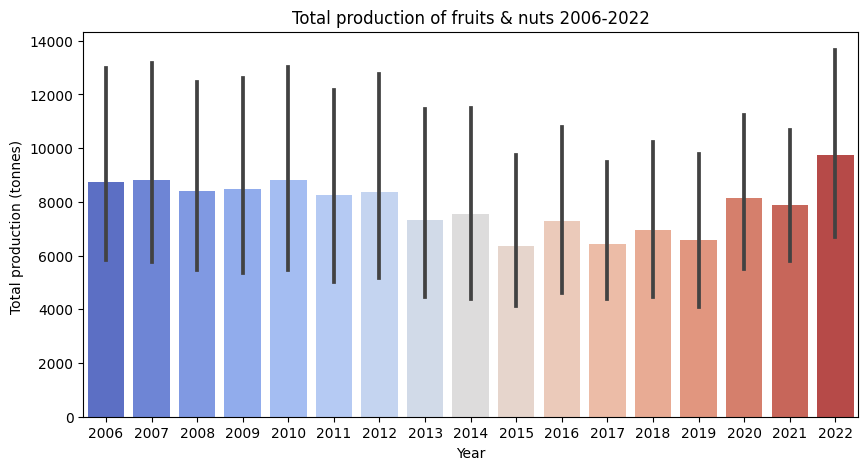

In [12]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Total_production',data = fruits_nuts_total_prod, palette='coolwarm')
plt.title('Total production of fruits & nuts 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes) ')
plt.show()



## Fruit production by Cities 

In [13]:
fruits_nuts_total_prod_region = fruits_nuts_total_prod.groupby(by = fruits_nuts_total_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False).head(10)
fruits_nuts_total_prod_region

,City,Total_production
98,Trentino Alto Adige / Südtirol,30030988.0
14,Bolzano / Bozen,19257494.9
99,Trento,9102960.5
26,Cosenza,8324209.4
21,Caserta,7701801.8
79,Ravenna,6937849.6
22,Catania,6701413.1
108,Verona,6390925.0
29,Cuneo,6345924.1
32,Ferrara,5603977.9


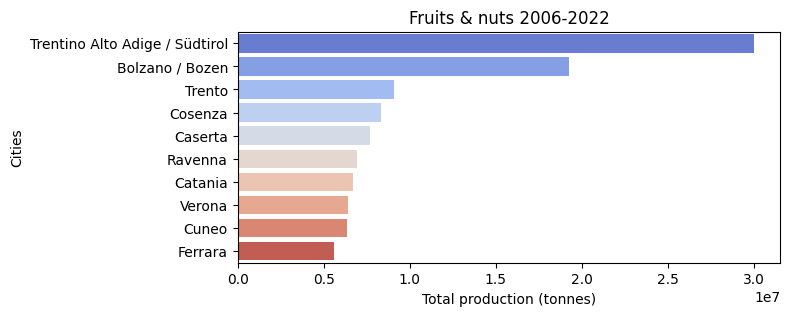

In [65]:
plt.figure(figsize= (7,3))
sns.barplot(x=fruits_nuts_total_prod_region['Total_production'],y= fruits_nuts_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Fruits & nuts 2006-2022')
plt.xlabel('Total production (tonnes)')
plt.ylabel('Cities')
plt.show()

## fruits_nuts produced 2006-2022

In [15]:
print(fruits_nuts_total_prod.Type_crop.max())
print(fruits_nuts_total_prod.Type_crop.value_counts())
print(fruits_nuts_total_prod.Type_crop.nunique())



white oranges (blancas)
pear                                                              1760
apple                                                             1732
peach                                                             1714
apricot                                                           1543
cherry in complex                                                 1506
plum                                                              1494
nectarine                                                         1391
kiwi                                                              1382
hazelnut                                                          1027
almond                                                             711
lemon                                                              672
mandarine                                                          595
fig                                                                583
clementine                                           

In [16]:
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('pears for fresh consumption', 'pears-fresh')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('peachs for fresh consumption', 'peachs-fresh')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('nectarines for fresh consumption', 'nectarines-fresh')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('apples for fresh consumption', 'apples-fresh')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('other berries excluding rowan', 'other-berries-no-rowan')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('other nuts (excluding pistachios)', 'other-nuts')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('other citrus fruits (excluding bergamots, cedars and chinotte)', 'other-citrus')
fruits_nuts_total_prod = fruits_nuts_total_prod.replace('other fruits from subtropical climate zones', 'other-fruits')


Dataset shows there are 55 different types of fruits and nuts cultivated in Italy. The top most produced crops are White oranges, Peach, Pear, Apples, Apricot, Cherry, Plum, Kiwi, Nectarine, Hazelnut, Almond and Raspberry. 

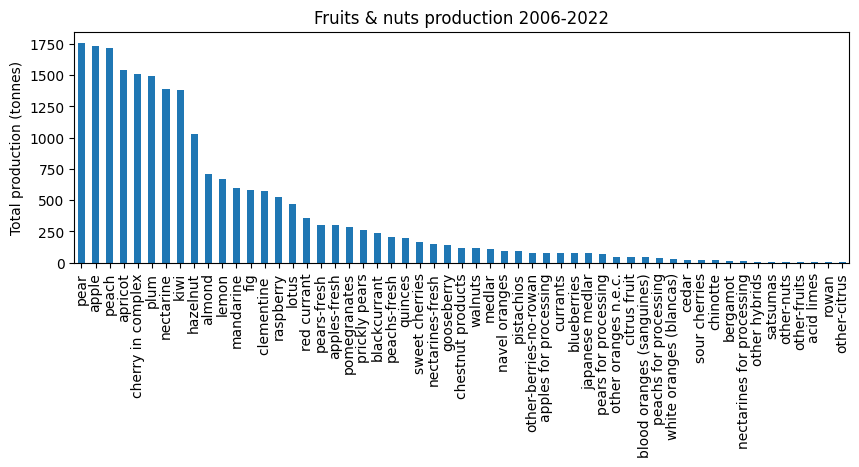

In [66]:
plt.figure(figsize=(10,3))
fruits_nuts_total_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Fruits & nuts production 2006-2022')
plt.ylabel('Total production (tonnes)')
plt.show()

## Subseting data

In [18]:
fruits_nuts_top10 = fruits_nuts_total_prod.apply(lambda row: row[fruits_nuts_total_prod['Type_crop'].isin(['peach', 'pear', 'apple', 'apricot', 'hazelnut',
                                                                                           'plum', 'kiwi', 'almond', 'cherry in complex','nectarine'])])

fruits_nuts_top10.head()

,City,Type_crop,Year,Total_production
103,Perugia,nectarine,2006,292.5
104,Perugia,nectarine,2007,285.0
105,Perugia,nectarine,2008,280.0
106,Perugia,nectarine,2009,280.0
107,Perugia,nectarine,2010,280.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'nectarine'),
  Text(1, 0, 'plum'),
  Text(2, 0, 'kiwi'),
  Text(3, 0, 'peach'),
  Text(4, 0, 'apple'),
  Text(5, 0, 'pear'),
  Text(6, 0, 'almond'),
  Text(7, 0, 'hazelnut'),
  Text(8, 0, 'apricot'),
  Text(9, 0, 'cherry in complex')])

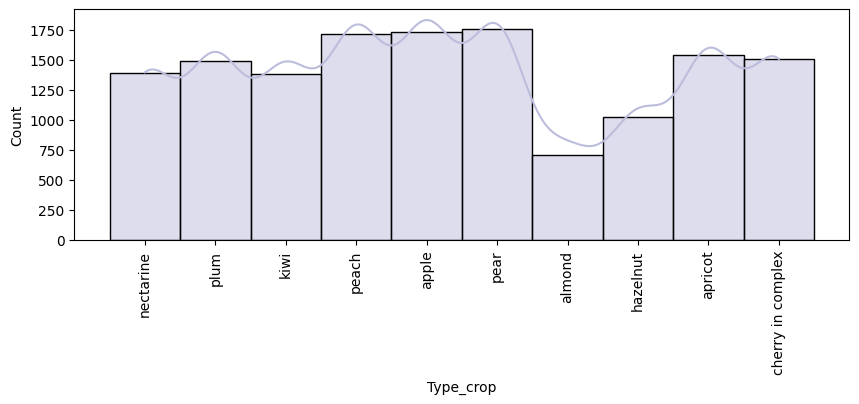

In [19]:
plt.figure(figsize=(10,3))
sns.histplot(fruits_nuts_top10, x="Type_crop", kde=True, color='#bcbddc')
plt.xticks(rotation = 90)

### Calculate and print the interquartile range

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [20]:
Q1 = fruits_nuts_top10.quantile(0.25)
Q3 = fruits_nuts_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                   8.00
Total_production    2178.25
dtype: float64


### Remove outliers and plot graphs

In [21]:
# Remove outliers

fruits_nuts_top10 = fruits_nuts_top10[~((fruits_nuts_top10 < (Q1 - 1.5 * IQR)) | (fruits_nuts_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]

print(fruits_nuts_top10.shape)

(12130, 4)


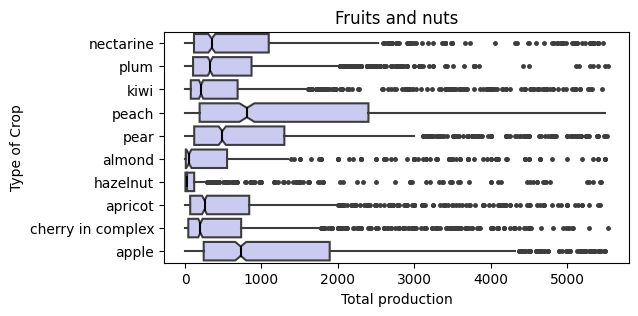

In [64]:
plt.figure(figsize=(6,3))

sns.boxplot(
    data=fruits_nuts_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.6, .6, .9, .5)},
    medianprops={"color": "black"},
)
plt.title('Fruits and nuts')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

(0.0, 6912.49488906913)

<Figure size 500x300 with 0 Axes>

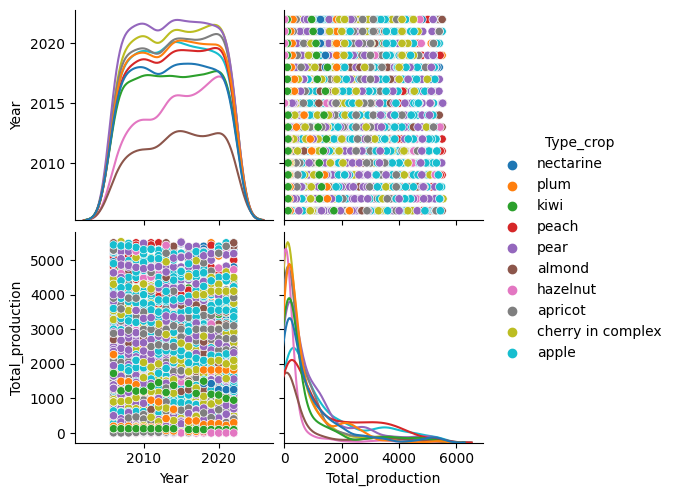

In [63]:
plt.figure(figsize=(5,3))
sns.pairplot(fruits_nuts_top10, hue="Type_crop", diag_kws=dict(fill=False))
plt.xlim(0, None)

In [67]:
fruits_nuts_top10.describe().astype(int)

,Year,Total_production
count,12130,12130
mean,2014,831
std,4,1173
min,2006,0
25%,2010,65
50%,2014,311
75%,2018,1069
max,2022,5532


## Vizualization of ten type of fruits & nuts produced in Italy in the period of 2006-2022 

<Figure size 500x300 with 0 Axes>

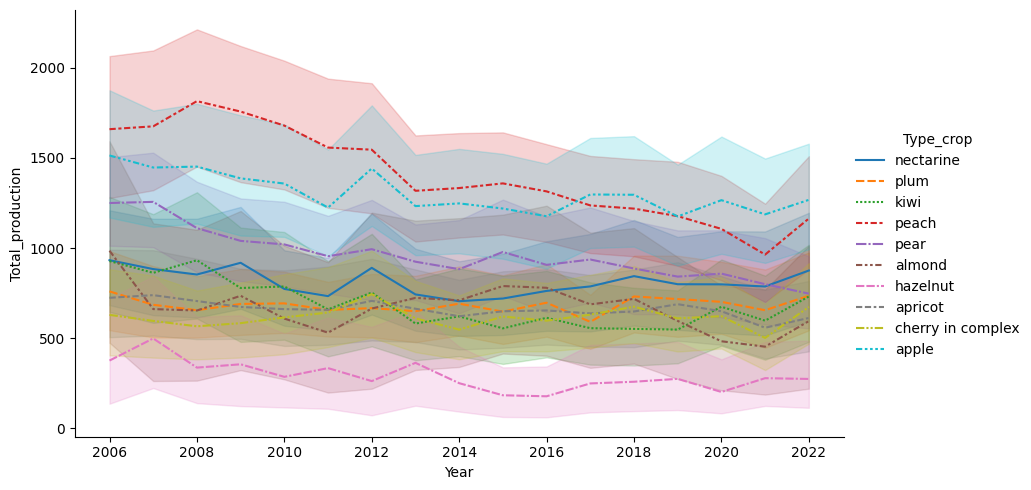

In [25]:
#Crop harvested by year
plt.figure(figsize=(5,3))
plotcrop10 = sns.relplot(kind='line', data=fruits_nuts_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


The relplot shows the mean and 95% CI for each crop.

### Create new column for each selected crop produced 

In [26]:
# Create columns for each type of fertilizer 
fruits_nuts_top10_pivot = fruits_nuts_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
fruits_nuts_top10_pivot

Total_production                                             \
Type_crop                almond   apple apricot cherry in complex hazelnut   
City      Year                                                               
Agrigento 2006              NaN  1292.0     NaN             335.8      NaN   
          2007              NaN  1428.0  5429.1             260.3      NaN   
          2008              NaN  1480.0     NaN             249.0      NaN   
          2009              NaN  1497.0     NaN             263.0      NaN   
          2010              NaN  1520.0     NaN             295.0      NaN   
...                         ...     ...     ...               ...      ...   
Viterbo   2018              NaN  2650.0   190.0             800.0      NaN   
          2019              NaN  1998.0   195.0             750.0      NaN   
          2020              NaN  2050.0   198.0             760.0      NaN   
          2021            220.0  2010.0   220.0             790.0      NaN   
          2022            890.0  2150.0   215.0             760.0      NaN   

                                                     
Type_crop       kiwi nectarine   peach  pear   plum  
City      Year                                       
Agrigento 2006  56.4    1710.0     NaN   NaN  368.0  
          2007  55.5    1692.4     NaN   NaN  431.3  
          2008   NaN    1598.0     NaN   NaN  404.8  
          2009   NaN    1613.0     NaN   NaN  462.0  
          2010   NaN    1688.5     NaN   NaN  476.0  
...              ...       ...     ...   ...    ...  
Viterbo   2018   NaN      28.5  2050.0   NaN  153.0  
          2019   NaN      27.0  1890.0  43.0  144.0  
          2020   NaN      26.5  1790.0  42.0  144.0  
          2021   NaN      19.0  1450.0  40.5  141.0  
          2022   NaN      22.0  1600.0  42.0  144.0  

[1819 rows x 10 columns]

In [27]:
# Drop level
fruits_nuts_top10_pivot.columns = fruits_nuts_top10_pivot.columns.droplevel()
fruits_nuts_top10_pivot

Type_crop       almond   apple  apricot  cherry in complex  hazelnut  kiwi  \
City      Year                                                               
Agrigento 2006     NaN  1292.0      NaN              335.8       NaN  56.4   
          2007     NaN  1428.0   5429.1              260.3       NaN  55.5   
          2008     NaN  1480.0      NaN              249.0       NaN   NaN   
          2009     NaN  1497.0      NaN              263.0       NaN   NaN   
          2010     NaN  1520.0      NaN              295.0       NaN   NaN   
...                ...     ...      ...                ...       ...   ...   
Viterbo   2018     NaN  2650.0    190.0              800.0       NaN   NaN   
          2019     NaN  1998.0    195.0              750.0       NaN   NaN   
          2020     NaN  2050.0    198.0              760.0       NaN   NaN   
          2021   220.0  2010.0    220.0              790.0       NaN   NaN   
          2022   890.0  2150.0    215.0              760.0       NaN   NaN   

Type_crop       nectarine   peach  pear   plum  
City      Year                                  
Agrigento 2006     1710.0     NaN   NaN  368.0  
          2007     1692.4     NaN   NaN  431.3  
          2008     1598.0     NaN   NaN  404.8  
          2009     1613.0     NaN   NaN  462.0  
          2010     1688.5     NaN   NaN  476.0  
...                   ...     ...   ...    ...  
Viterbo   2018       28.5  2050.0   NaN  153.0  
          2019       27.0  1890.0  43.0  144.0  
          2020       26.5  1790.0  42.0  144.0  
          2021       19.0  1450.0  40.5  141.0  
          2022       22.0  1600.0  42.0  144.0  

[1819 rows x 10 columns]

In [28]:
fruits_nuts_top10_pivot = fruits_nuts_top10_pivot.fillna(0)
fruits_nuts_top10_pivot

Type_crop       almond   apple  apricot  cherry in complex  hazelnut  kiwi  \
City      Year                                                               
Agrigento 2006     0.0  1292.0      0.0              335.8       0.0  56.4   
          2007     0.0  1428.0   5429.1              260.3       0.0  55.5   
          2008     0.0  1480.0      0.0              249.0       0.0   0.0   
          2009     0.0  1497.0      0.0              263.0       0.0   0.0   
          2010     0.0  1520.0      0.0              295.0       0.0   0.0   
...                ...     ...      ...                ...       ...   ...   
Viterbo   2018     0.0  2650.0    190.0              800.0       0.0   0.0   
          2019     0.0  1998.0    195.0              750.0       0.0   0.0   
          2020     0.0  2050.0    198.0              760.0       0.0   0.0   
          2021   220.0  2010.0    220.0              790.0       0.0   0.0   
          2022   890.0  2150.0    215.0              760.0       0.0   0.0   

Type_crop       nectarine   peach  pear   plum  
City      Year                                  
Agrigento 2006     1710.0     0.0   0.0  368.0  
          2007     1692.4     0.0   0.0  431.3  
          2008     1598.0     0.0   0.0  404.8  
          2009     1613.0     0.0   0.0  462.0  
          2010     1688.5     0.0   0.0  476.0  
...                   ...     ...   ...    ...  
Viterbo   2018       28.5  2050.0   0.0  153.0  
          2019       27.0  1890.0  43.0  144.0  
          2020       26.5  1790.0  42.0  144.0  
          2021       19.0  1450.0  40.5  141.0  
          2022       22.0  1600.0  42.0  144.0  

[1819 rows x 10 columns]

In [29]:
#Rename index
fruits_nuts_top10_pivot = fruits_nuts_top10_pivot.rename_axis(None,axis=1)
fruits_nuts_top10_pivot

almond   apple  apricot  cherry in complex  hazelnut  kiwi  \
City      Year                                                               
Agrigento 2006     0.0  1292.0      0.0              335.8       0.0  56.4   
          2007     0.0  1428.0   5429.1              260.3       0.0  55.5   
          2008     0.0  1480.0      0.0              249.0       0.0   0.0   
          2009     0.0  1497.0      0.0              263.0       0.0   0.0   
          2010     0.0  1520.0      0.0              295.0       0.0   0.0   
...                ...     ...      ...                ...       ...   ...   
Viterbo   2018     0.0  2650.0    190.0              800.0       0.0   0.0   
          2019     0.0  1998.0    195.0              750.0       0.0   0.0   
          2020     0.0  2050.0    198.0              760.0       0.0   0.0   
          2021   220.0  2010.0    220.0              790.0       0.0   0.0   
          2022   890.0  2150.0    215.0              760.0       0.0   0.0   

                nectarine   peach  pear   plum  
City      Year                                  
Agrigento 2006     1710.0     0.0   0.0  368.0  
          2007     1692.4     0.0   0.0  431.3  
          2008     1598.0     0.0   0.0  404.8  
          2009     1613.0     0.0   0.0  462.0  
          2010     1688.5     0.0   0.0  476.0  
...                   ...     ...   ...    ...  
Viterbo   2018       28.5  2050.0   0.0  153.0  
          2019       27.0  1890.0  43.0  144.0  
          2020       26.5  1790.0  42.0  144.0  
          2021       19.0  1450.0  40.5  141.0  
          2022       22.0  1600.0  42.0  144.0  

[1819 rows x 10 columns]

In [30]:
# Reset index
fruits_nuts_top10_pivot = fruits_nuts_top10_pivot.reset_index()
fruits_nuts_top10_pivot

,City,Year,almond,apple,apricot,cherry in complex,hazelnut,kiwi,nectarine,peach,pear,plum
0,Agrigento,2006,0.0,1292.0,0.0,335.8,0.0,56.4,1710.0,0.0,0.0,368.0
1,Agrigento,2007,0.0,1428.0,5429.1,260.3,0.0,55.5,1692.4,0.0,0.0,431.3
2,Agrigento,2008,0.0,1480.0,0.0,249.0,0.0,0.0,1598.0,0.0,0.0,404.8
3,Agrigento,2009,0.0,1497.0,0.0,263.0,0.0,0.0,1613.0,0.0,0.0,462.0
4,Agrigento,2010,0.0,1520.0,0.0,295.0,0.0,0.0,1688.5,0.0,0.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1814,Viterbo,2018,0.0,2650.0,190.0,800.0,0.0,0.0,28.5,2050.0,0.0,153.0
1815,Viterbo,2019,0.0,1998.0,195.0,750.0,0.0,0.0,27.0,1890.0,43.0,144.0
1816,Viterbo,2020,0.0,2050.0,198.0,760.0,0.0,0.0,26.5,1790.0,42.0,144.0
1817,Viterbo,2021,220.0,2010.0,220.0,790.0,0.0,0.0,19.0,1450.0,40.5,141.0


## Statistical analysis

In [31]:
fruits_nuts_top10_pivot.describe()

,Year,almond,apple,apricot,cherry in complex,hazelnut,kiwi,nectarine,peach,pear,plum
count,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,2014.058824,227.574162,942.904288,500.921770,487.123255,143.202804,429.254096,526.200055,980.209511,803.396537,501.512259
std,4.877752,795.991198,1327.657577,893.038196,905.837017,591.736933,946.598939,968.186039,1356.835691,1156.120896,804.144819
min,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,0.000000,0.000000,5.250000,6.000000,0.000000,0.000000,0.000000,0.000000,33.500000,0.000000
50%,2014.000000,0.000000,315.000000,106.000000,80.000000,0.200000,55.500000,100.000000,255.000000,300.500000,151.000000
75%,2018.000000,15.900000,1258.500000,630.000000,500.000000,25.250000,315.000000,655.000000,1588.250000,1100.000000,604.000000
max,2022.000000,5500.000000,5500.000000,5429.100000,5532.000000,5440.400000,5460.000000,5474.000000,5500.000000,5520.000000,5530.000000


#### Data metrics : skew, kurtosis and mode

In [32]:
fruits_nuts_top10_pivot_stats = fruits_nuts_top10_pivot[['peach', 'pear', 'apple', 'apricot', 'hazelnut','plum', 'kiwi',
                                                     'almond', 'cherry in complex','nectarine']]

print(fruits_nuts_top10_pivot_stats.astype(float).skew())
print(fruits_nuts_top10_pivot_stats.astype(float).kurtosis())
print(fruits_nuts_top10_pivot_stats.astype(float).mode())


peach                1.415263
pear                 2.038039
apple                1.666312
apricot              2.901920
hazelnut             6.229698
plum                 2.477223
kiwi                 3.222570
almond               4.285016
cherry in complex    2.838373
nectarine            2.924429
dtype: float64
peach                 0.908999
pear                  3.883850
apple                 1.858335
apricot               9.278060
hazelnut             41.931298
plum                  7.338370
kiwi                 10.408869
almond               18.596233
cherry in complex     8.359449
nectarine             9.617321
dtype: float64
   peach  pear  apple  apricot  hazelnut  plum  kiwi  almond  \
0    0.0   0.0    0.0      0.0       0.0   0.0   0.0     0.0   

   cherry in complex  nectarine  
0                0.0        0.0  


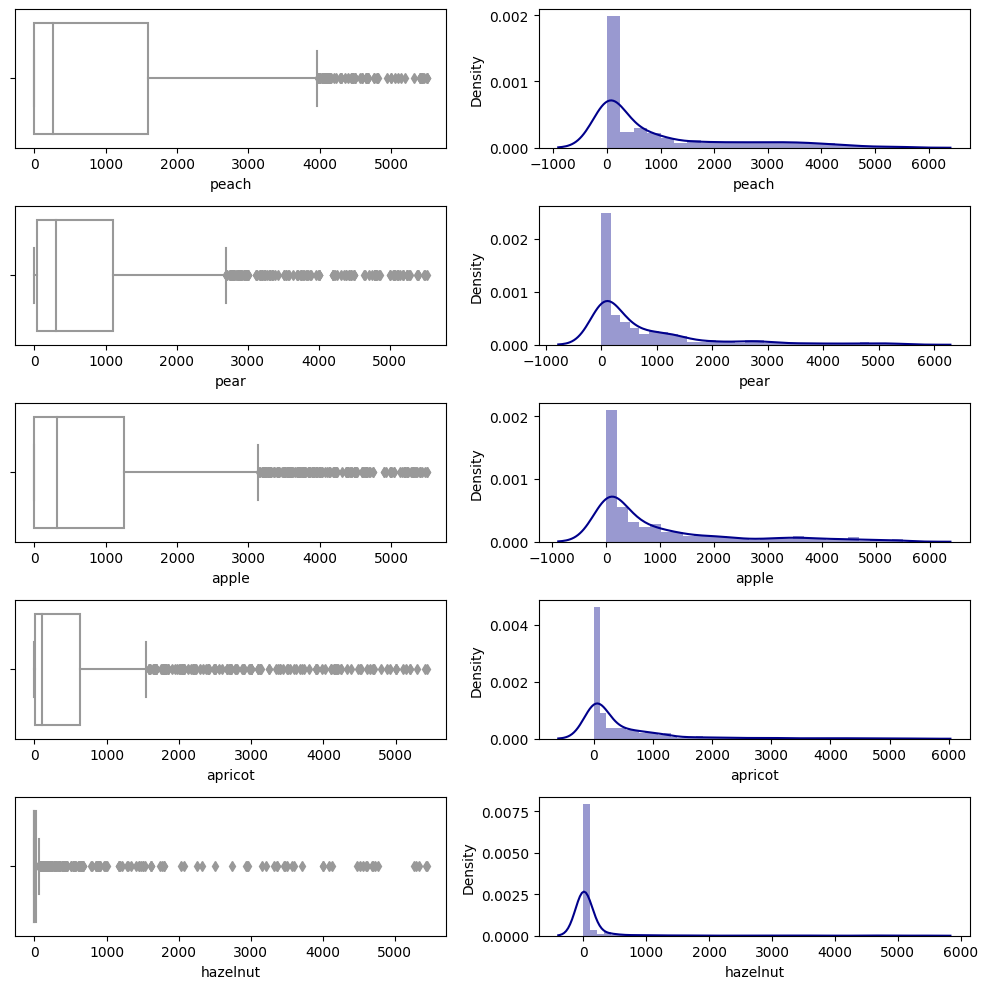

In [33]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= fruits_nuts_top10_pivot_stats["peach"], color = 'white', ax = ax[0,0])
sns.distplot(fruits_nuts_top10_pivot_stats['peach'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["pear"],color = 'white', ax = ax[1,0])
sns.distplot(fruits_nuts_top10_pivot_stats['pear'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["apple"],color = 'white', ax = ax[2,0])
sns.distplot(fruits_nuts_top10_pivot_stats['apple'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["apricot"], color = 'white', ax = ax[3,0])
sns.distplot(fruits_nuts_top10_pivot_stats['apricot'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["hazelnut"], color = 'white',ax = ax[4,0])
sns.distplot(fruits_nuts_top10_pivot_stats['hazelnut'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

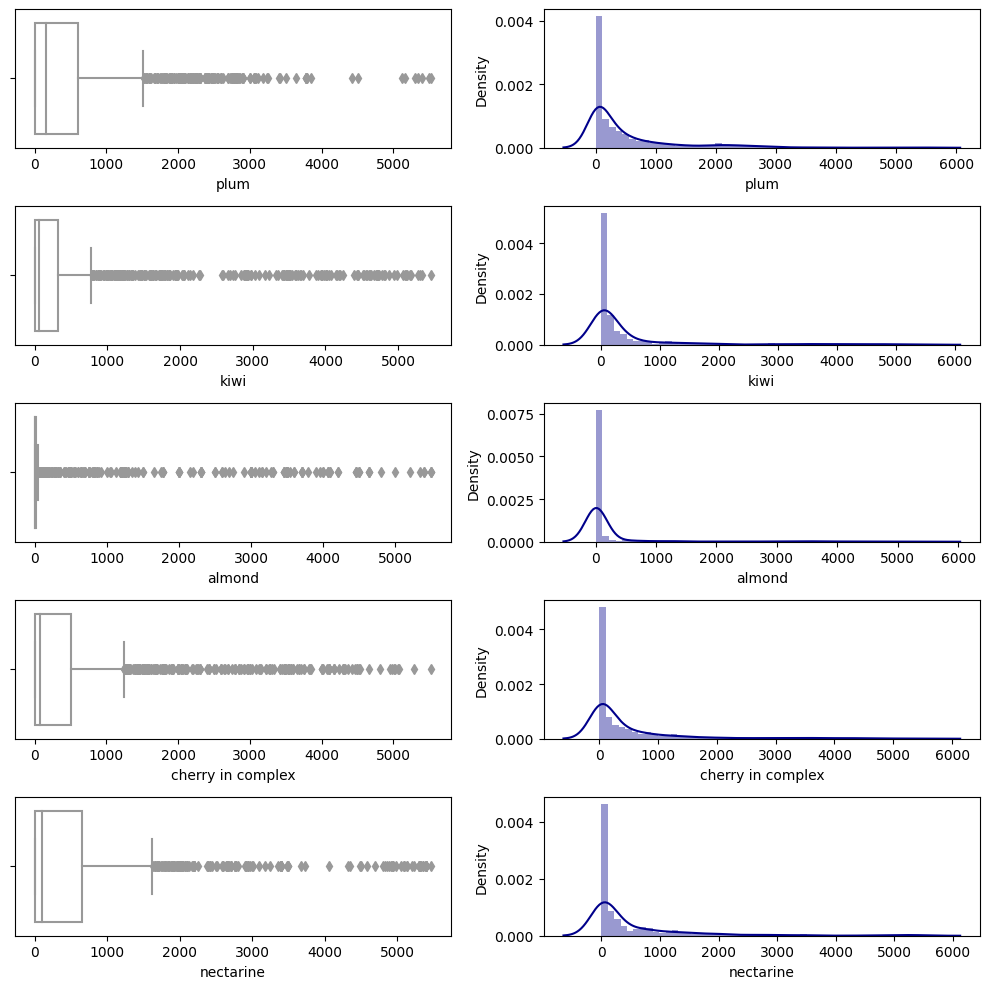

In [34]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= fruits_nuts_top10_pivot_stats["plum"], color = 'white', ax = ax[0,0])
sns.distplot(fruits_nuts_top10_pivot_stats['plum'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["kiwi"],color = 'white', ax = ax[1,0])
sns.distplot(fruits_nuts_top10_pivot_stats['kiwi'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["almond"],color = 'white', ax = ax[2,0])
sns.distplot(fruits_nuts_top10_pivot_stats['almond'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["cherry in complex"], color = 'white',ax = ax[3,0])
sns.distplot(fruits_nuts_top10_pivot_stats['cherry in complex'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["nectarine"], color = 'white',ax = ax[4,0])
sns.distplot(fruits_nuts_top10_pivot_stats['nectarine'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

### Pre-processing fertilizer dataset 

In [35]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [36]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [37]:
#fertilizer.Territory.unique()

In [38]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [39]:
#convert quintals to tonnes
fertilizer.loc[fertilizer['Data_type'] == 'fertilizers distributed - quintals','Fertilizers_tonnes' ] = fertilizer['Fertilizers_tonnes'] / 10



In [40]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335.0
68382,Sud Sardegna,specific action products -,2018,137.0
68383,Sud Sardegna,specific action products -,2019,164.0
68384,Sud Sardegna,specific action products -,2020,135.0


## Select fertilizers 

In [41]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [42]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [43]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [44]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['organic','nitrogen-potassium',
                                                                                  'nitrogen-phosphorous'])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
88,Torino,nitrogen-phosphorous,2006,13448.7
89,Torino,nitrogen-phosphorous,2007,15689.3
90,Torino,nitrogen-phosphorous,2008,8672.4
91,Torino,nitrogen-phosphorous,2009,7766.9
92,Torino,nitrogen-phosphorous,2010,9253.3


In [45]:
fertilizer.describe()

,Year,Fertilizers_tonnes
count,6996.000000,6996.000000
mean,2013.493997,1539.149743
std,4.587903,3587.481455
min,2006.000000,0.000000
25%,2010.000000,45.975000
50%,2013.000000,371.000000
75%,2017.000000,1544.625000
max,2021.000000,98671.600000


<AxesSubplot: >

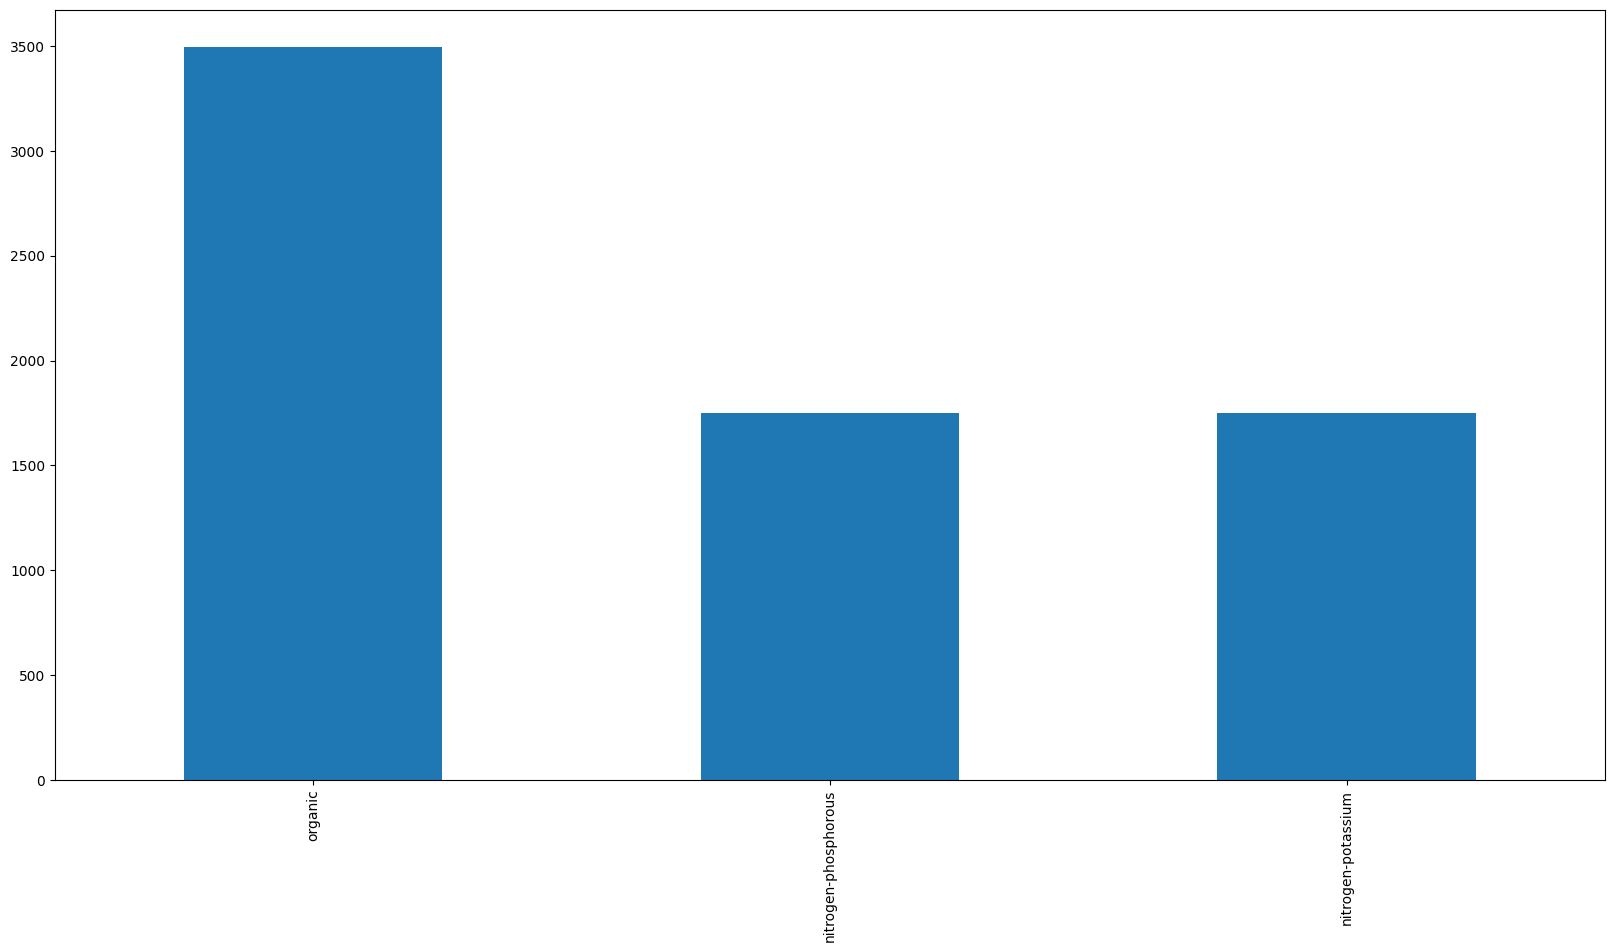

In [46]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()

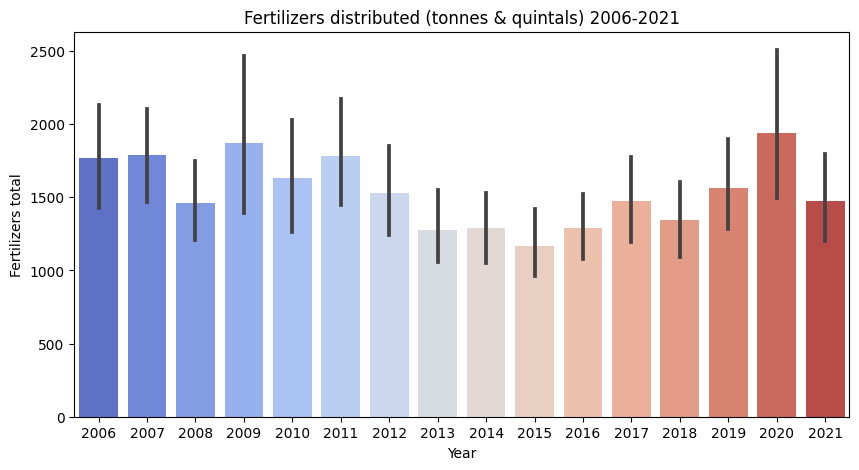

In [47]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


In [48]:
region = fertilizer.nlargest(30, 'Fertilizers_tonnes')

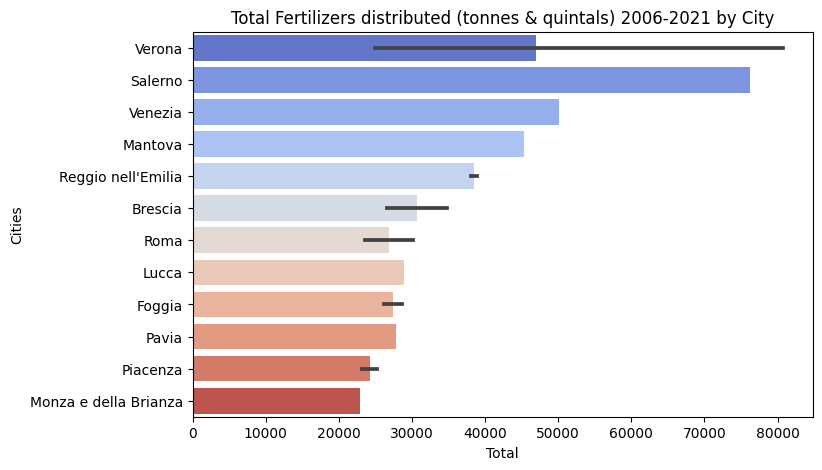

In [49]:
plt.figure(figsize= (8,5))
sns.barplot(x=region['Fertilizers_tonnes'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

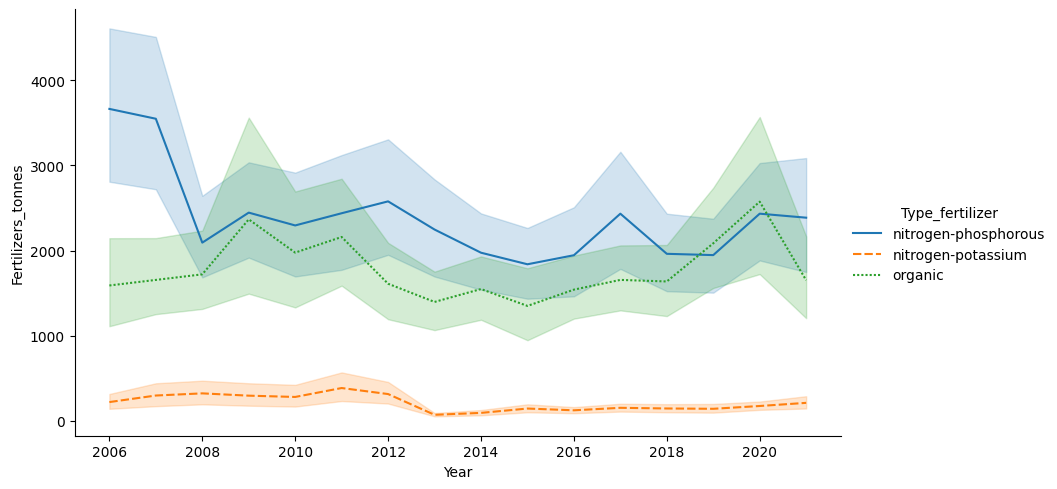

In [50]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [51]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                           
Type_fertilizer nitrogen-phosphorous nitrogen-potassium organic
City      Year                                                 
Agrigento 2006                 497.7               27.7  3143.9
          2007                 649.8               49.1  3534.8
          2008                 521.3               61.4  3750.4
          2009                 380.8               46.8  2791.4
          2010                 327.1               44.0  2346.0
...                              ...                ...     ...
Viterbo   2017                4732.0               66.0  1760.0
          2018                4376.0               19.0  1591.0
          2019                3964.0              195.0  1251.0
          2020                6145.0               98.0  1236.0
          2021                3946.0              112.0  1056.0

[1749 rows x 3 columns]

In [52]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                    
Agrigento 2006                  497.7                27.7   3143.9
          2007                  649.8                49.1   3534.8
          2008                  521.3                61.4   3750.4
          2009                  380.8                46.8   2791.4
          2010                  327.1                44.0   2346.0
...                               ...                 ...      ...
Viterbo   2017                 4732.0                66.0   1760.0
          2018                 4376.0                19.0   1591.0
          2019                 3964.0               195.0   1251.0
          2020                 6145.0                98.0   1236.0
          2021                 3946.0               112.0   1056.0

[1749 rows x 3 columns]

In [53]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                   
Agrigento 2006                 497.7                27.7   3143.9
          2007                 649.8                49.1   3534.8
          2008                 521.3                61.4   3750.4
          2009                 380.8                46.8   2791.4
          2010                 327.1                44.0   2346.0
...                              ...                 ...      ...
Viterbo   2017                4732.0                66.0   1760.0
          2018                4376.0                19.0   1591.0
          2019                3964.0               195.0   1251.0
          2020                6145.0                98.0   1236.0
          2021                3946.0               112.0   1056.0

[1749 rows x 3 columns]

In [54]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,497.7,27.7,3143.9
1,Agrigento,2007,649.8,49.1,3534.8
2,Agrigento,2008,521.3,61.4,3750.4
3,Agrigento,2009,380.8,46.8,2791.4
4,Agrigento,2010,327.1,44.0,2346.0
...,...,...,...,...,...
1744,Viterbo,2017,4732.0,66.0,1760.0
1745,Viterbo,2018,4376.0,19.0,1591.0
1746,Viterbo,2019,3964.0,195.0,1251.0
1747,Viterbo,2020,6145.0,98.0,1236.0


In [55]:
# Join both datasets 
it_crop_ferlizer = pd.merge(fruits_nuts_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer


,City,Year,almond,apple,apricot,cherry in complex,hazelnut,kiwi,nectarine,peach,pear,plum,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,0.0,1292.0,0.0,335.8,0.0,56.4,1710.0,0.0,0.0,368.0,497.7,27.7,3143.9
1,Agrigento,2007,0.0,1428.0,5429.1,260.3,0.0,55.5,1692.4,0.0,0.0,431.3,649.8,49.1,3534.8
2,Agrigento,2008,0.0,1480.0,0.0,249.0,0.0,0.0,1598.0,0.0,0.0,404.8,521.3,61.4,3750.4
3,Agrigento,2009,0.0,1497.0,0.0,263.0,0.0,0.0,1613.0,0.0,0.0,462.0,380.8,46.8,2791.4
4,Agrigento,2010,0.0,1520.0,0.0,295.0,0.0,0.0,1688.5,0.0,0.0,476.0,327.1,44.0,2346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,Viterbo,2018,0.0,2650.0,190.0,800.0,0.0,0.0,28.5,2050.0,0.0,153.0,4376.0,19.0,1591.0
1815,Viterbo,2019,0.0,1998.0,195.0,750.0,0.0,0.0,27.0,1890.0,43.0,144.0,3964.0,195.0,1251.0
1816,Viterbo,2020,0.0,2050.0,198.0,760.0,0.0,0.0,26.5,1790.0,42.0,144.0,6145.0,98.0,1236.0
1817,Viterbo,2021,220.0,2010.0,220.0,790.0,0.0,0.0,19.0,1450.0,40.5,141.0,3946.0,112.0,1056.0


## Correlation 

In [56]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['peach', 'pear', 'apple', 'apricot', 'hazelnut','plum', 
                                 'kiwi','almond', 'cherry in complex','nectarine',
                                  'organic','nitrogen-potassium',
                                    'nitrogen-phosphorous']] 



<AxesSubplot: title={'center': 'Correlation'}>

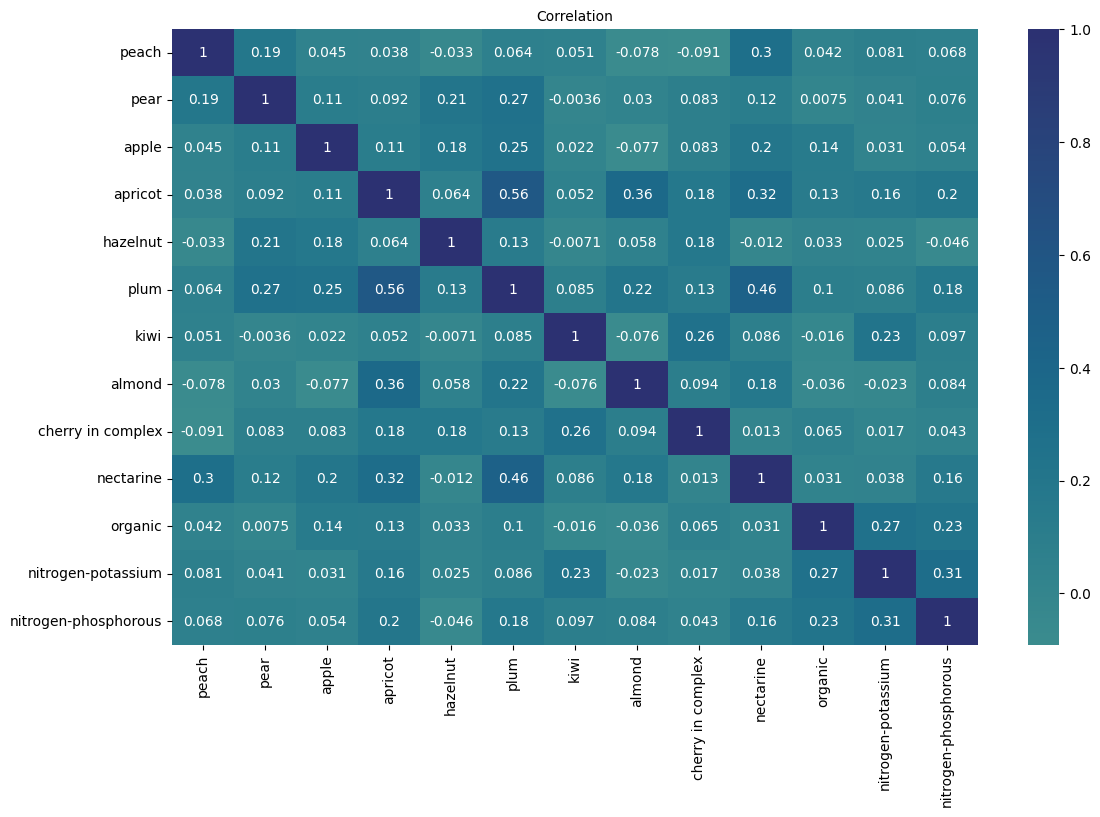

In [70]:
plt.figure(figsize=(13,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of fruits & nuts production in Italy 2006-2020

* Apple has low correlation with fertilizers and other crops.

* Apricot has a high correlation with Plum and Nectarine.

* Kiwi has high correlation with Plum.

* Nectarine has a high correlation with Plum, Apricot and Peach.




### Calculating Variance Inflation Factor (VIF) for all given features


In [58]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [59]:
# Features selection
selected_features = ['peach', 'pear', 'apple', 'apricot', 'hazelnut','plum', 
                     'kiwi','almond', 'cherry in complex','nectarine',
                     'organic','nitrogen-potassium',
                       'nitrogen-phosphorous']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)

,Feature,VIF
5,plum,1.876480
3,apricot,1.702110
9,nectarine,1.470062
11,nitrogen-potassium,1.253562
7,almond,1.233794
12,nitrogen-phosphorous,1.192458
0,peach,1.187311
6,kiwi,1.186355
8,cherry in complex,1.184239
1,pear,1.180002


The variable Calcium-cyanamide has showed in the Variance Inflation Factor (VIF) = inf (infinity), The result shows perfect correlation and multicolinearity, the causes can vary therefore for the purpose of this work  the variable will not be used in the model.  

Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html


https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/